# Comparative Analysis of 'dag2pag' Implementation with R Package 'pcalg'

This notebook presents a detailed comparison between the Python implementation of `dag2pag` and the corresponding function from the R package `pcalg`. The analysis includes generating random DAGs, converting them to PAGs, and identifying any discrepancies between the results produced by both methods.

In [1]:
import os
from fastdag2pag.dag2pag import dag2pag
from fastdag2pag.Random_Graph import ErdosRenyi
import json 
import pandas as pd
import io
import tqdm
from tqdm import tqdm

## Test the dag2pag function with Erdos-Renyi graphs and save the results to a JSON file

In [2]:
# Test the dag2pag function with Erdos-Renyi graphs and save the results to a JSON file
def test_dag_to_pag(num_nodes = 30, expected_degree = 3, num_tests = 100):
    """
    Test the dag2pag function with Erdos-Renyi graphs.
    """

    # ER_graph_gen = ErdosRenyi(num_nodes, expected_degree, def_dataframe=True, seed=123)

    # graphs = []
    # for i in tqdm(range(num_tests)):
    #     graph = ER_graph_gen.get_random_graph()
    #     graph = ER_graph_gen.set_latent_nodes(graph, latent_rate=0.3, selection_bias = False, debug=False)

    #     graph_information = {
    #         "id": i+1,
    #         "graph": graph.to_csv(index=True)
    #     }
    #     graphs.append(graph_information)

    # path = f"Test_Data/dags_{num_nodes}_{expected_degree}.json"
    # with open(path, "w") as f:
    #     json.dump(graphs, f)

    load_graphs_paths = f"Test_Data/dags_{num_nodes}_{expected_degree}.json"
    with open(load_graphs_paths, "r") as f:
        graphs = json.load(f)

    pags = []
    for i in tqdm(range(100)):
        graph = graphs[i]
        graph_csv = graph["graph"]
        graph_df = pd.read_csv(io.StringIO(graph_csv), index_col=0)
        latent_variables = [node for node in graph_df.columns if node.startswith('L')] # 
        latent_variables = [node for node in graph_df.columns if node.startswith('L')]
        result = dag2pag(graph_df, latent_nodes=latent_variables)
        pag_df = result['PAG.DataFrame']

        pag_information = {
            "id": graph["id"],
            "graph": pag_df.to_csv(index=True)
        }

        pags.append(pag_information)

    # Save the PAGs to a JSON file
    with open(f"Test_Data/dag2pag_pags_{num_nodes}_{expected_degree}.json", "w") as f:
        json.dump(pags, f)



num_nodes = 30
expected_degree = 3
num_tests = 100
test_dag_to_pag(num_nodes, expected_degree, num_tests)

100%|██████████| 100/100 [00:06<00:00, 15.52it/s]


### Please run `dag_to_pag_test.R` first to generate the result file for pcalg before executing the `compare_pags` function.

In [3]:
# The compare function to identify discrepancies between the two implementations
def compare_pags(num_nodes = 30, expected_degree = 3):
    

    path = f"Test_Data/pcalg_pags_{num_nodes}_{expected_degree}.json"
    with open(path, "r") as f:
        pcalg_pags = json.load(f)

    path = f"Test_Data/dag2pag_pags_{num_nodes}_{expected_degree}.json" 
    with open(path, "r") as f:
        dag2pag_py_pags = json.load(f)

    diff_ids = []
    for py_pag_info, pcalg_info in tqdm(zip(dag2pag_py_pags, pcalg_pags)):
        py_pag_id = py_pag_info["id"]
        py_pag_csv = py_pag_info["graph"]
        py_pag_df = pd.read_csv(io.StringIO(py_pag_csv), index_col=0)

        pcalg_id = pcalg_info["id"]
        pcalg_csv = pcalg_info["graph"]
        pcalg_df = pd.read_csv(io.StringIO(pcalg_csv), index_col=0)

  
        # Compare the DataFrames
        if not py_pag_df.equals(pcalg_df):
            print(f"Discrepancy found in graph {py_pag_id}")
            diff = py_pag_df.compare(pcalg_df, result_names=("py_pag", "R_pag"))
            print(diff)
            diff_ids.append(py_pag_id)
    return diff_ids


diff_dis = compare_pags(num_nodes, expected_degree)
print("Graphs with discrepancies:", diff_dis)

100it [00:00, 567.16it/s]

Discrepancy found in graph 2
        V8          V11          V12          V14          V15          V19  \
    py_pag R_pag py_pag R_pag py_pag R_pag py_pag R_pag py_pag R_pag py_pag   
V12    NaN   NaN    NaN   NaN    NaN   NaN    1.0   2.0    NaN   NaN    NaN   
V20    NaN   NaN    NaN   NaN    NaN   NaN    1.0   2.0    NaN   NaN    NaN   
V21    NaN   NaN    NaN   NaN    NaN   NaN    1.0   3.0    NaN   NaN    NaN   
V26    NaN   NaN    NaN   NaN    NaN   NaN    1.0   2.0    1.0   2.0    NaN   
V27    NaN   NaN    NaN   NaN    NaN   NaN    1.0   2.0    NaN   NaN    NaN   
V30    1.0   3.0    1.0   3.0    1.0   0.0    1.0   2.0    1.0   2.0    1.0   

             V20          V26          V27          V30        
    R_pag py_pag R_pag py_pag R_pag py_pag R_pag py_pag R_pag  
V12   NaN    NaN   NaN    NaN   NaN    NaN   NaN    2.0   0.0  
V20   NaN    NaN   NaN    NaN   NaN    NaN   NaN    NaN   NaN  
V21   NaN    NaN   NaN    NaN   NaN    NaN   NaN    NaN   NaN  
V26   NaN    NaN  

### I find there are some discrepancies between the two implementations.


I have plotted the DAGs that lead to discrepancies. By examining these plots, I found that the `dag2pag` function in the `pcalg` package does not behave correctly. Specifically, in some cases where there is an inducing path between two observed nodes relative to latent variables, `dag2pag` in `pcalg` fails to add an edge between these observed nodes.

A path p between X and Y is called an inducing path relative to latent variables L and selection variables S if every non-endpoint vertex on p is either in L or a collider, and every collider on p is an ancestor of X, Y, or a member of S.


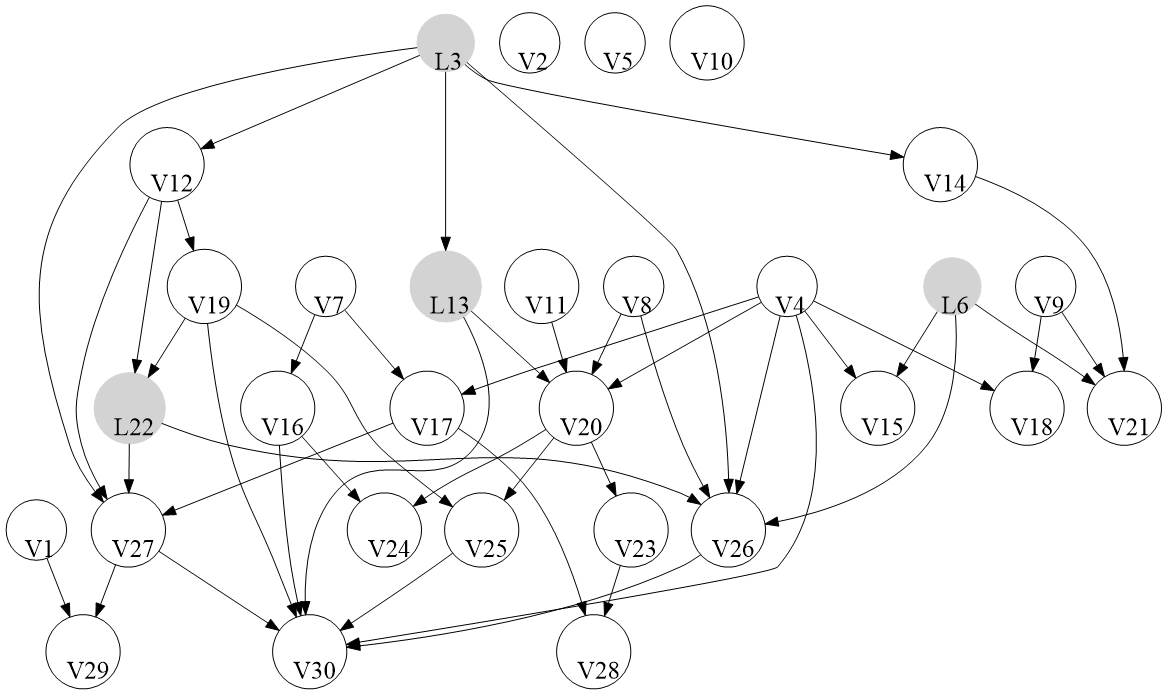

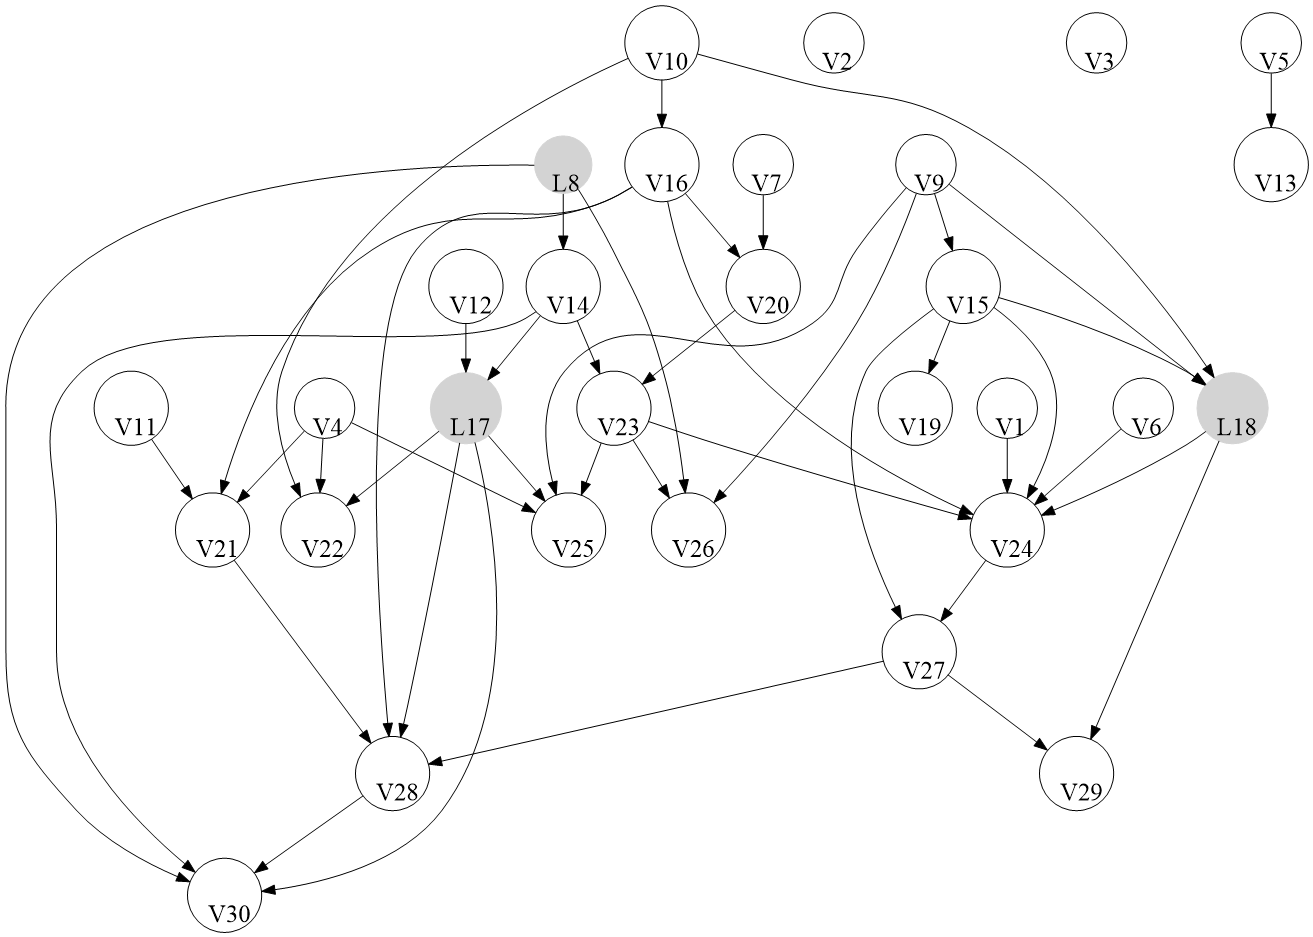

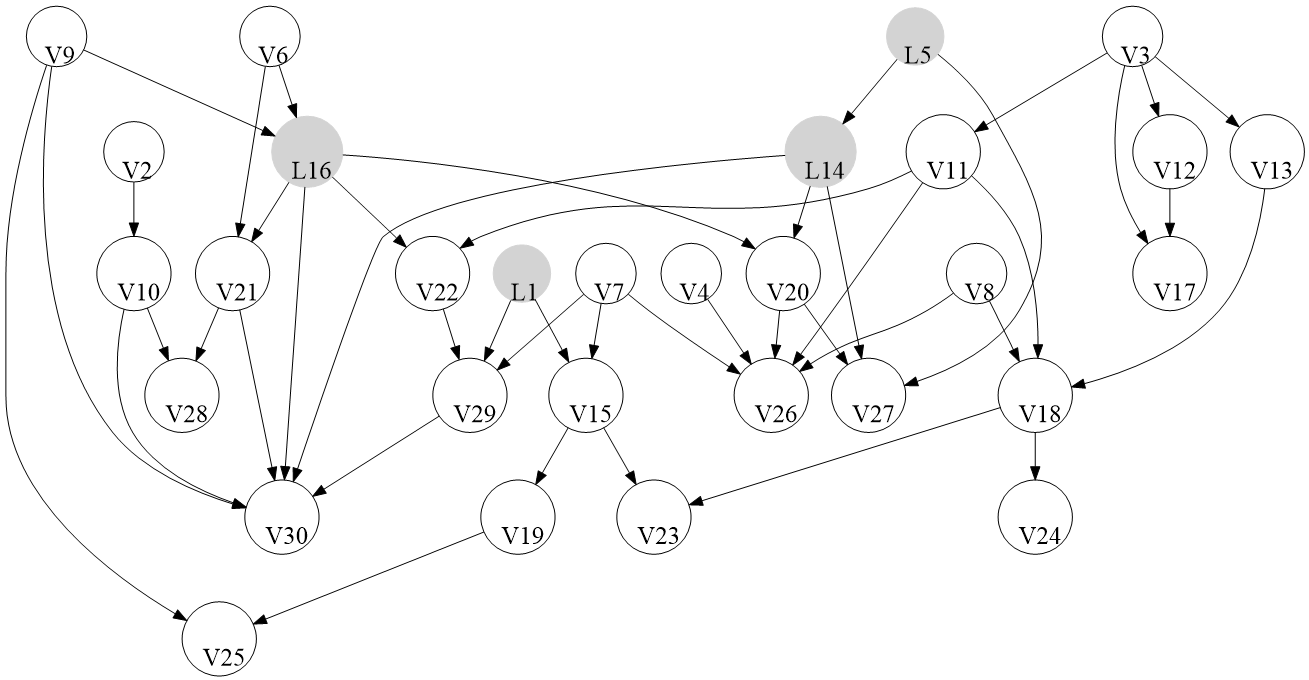

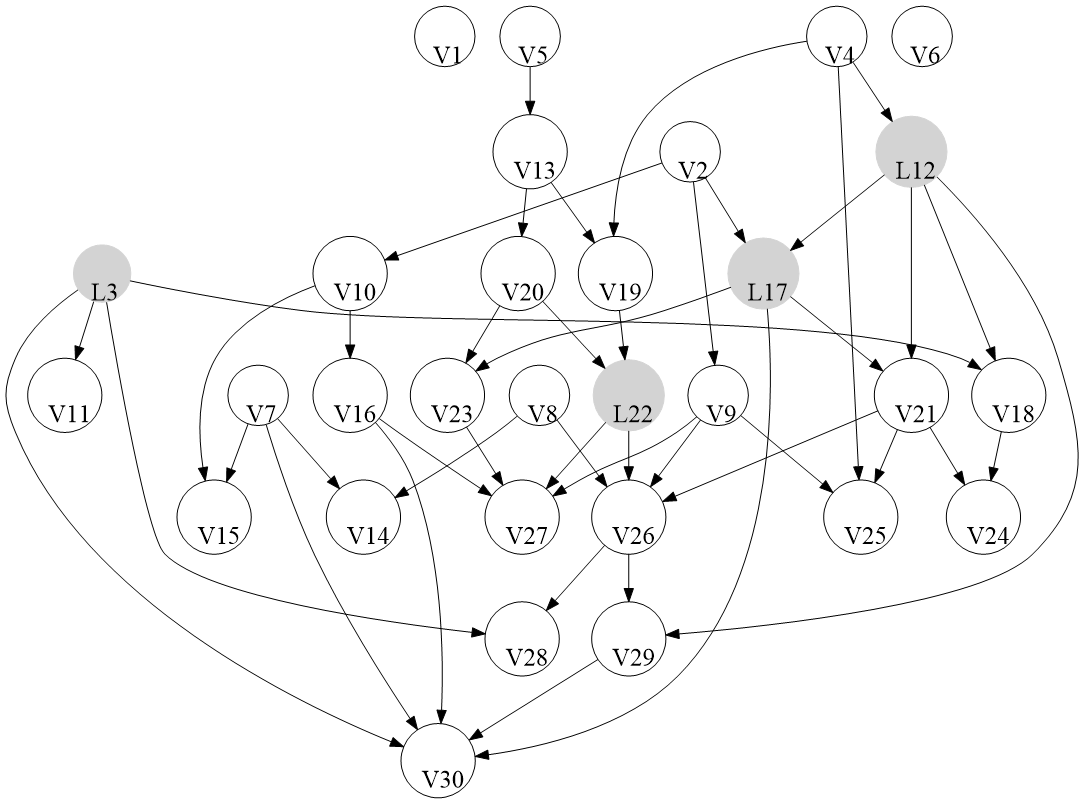

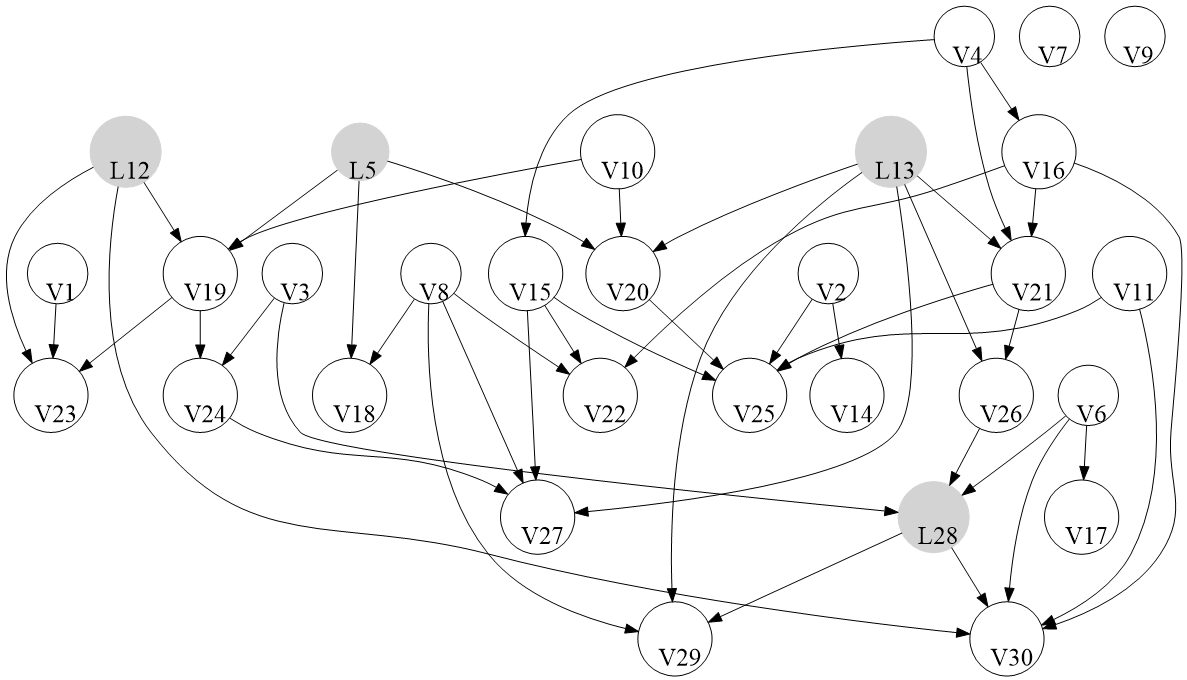

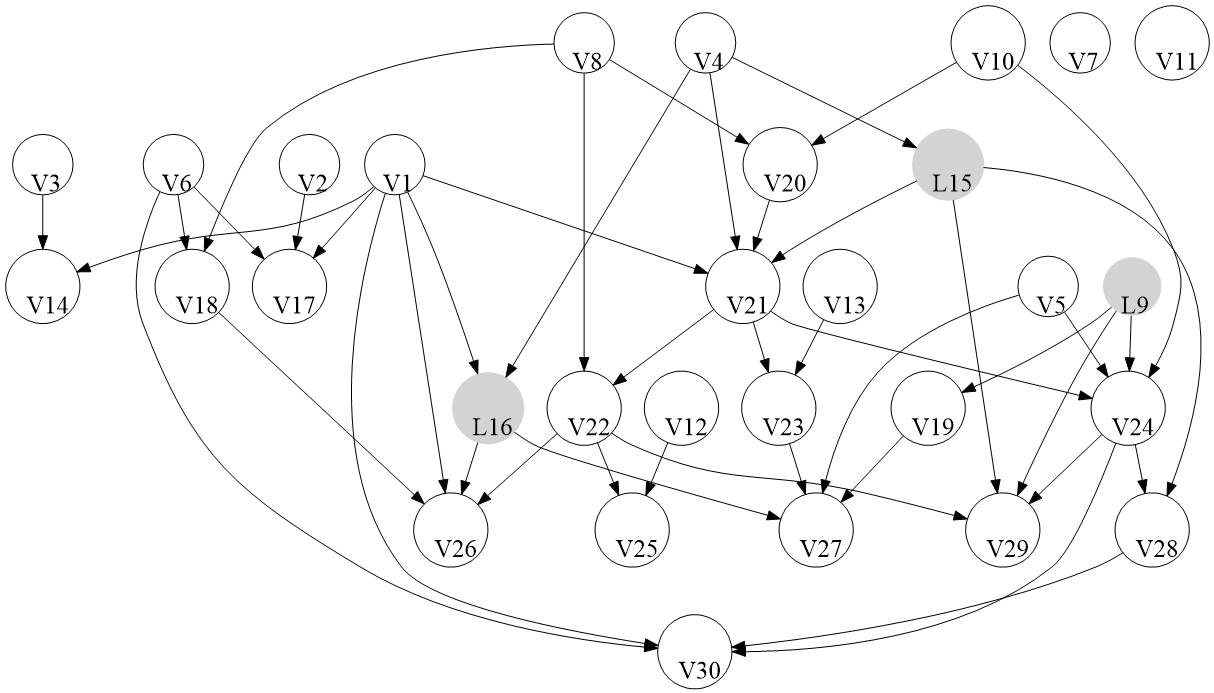

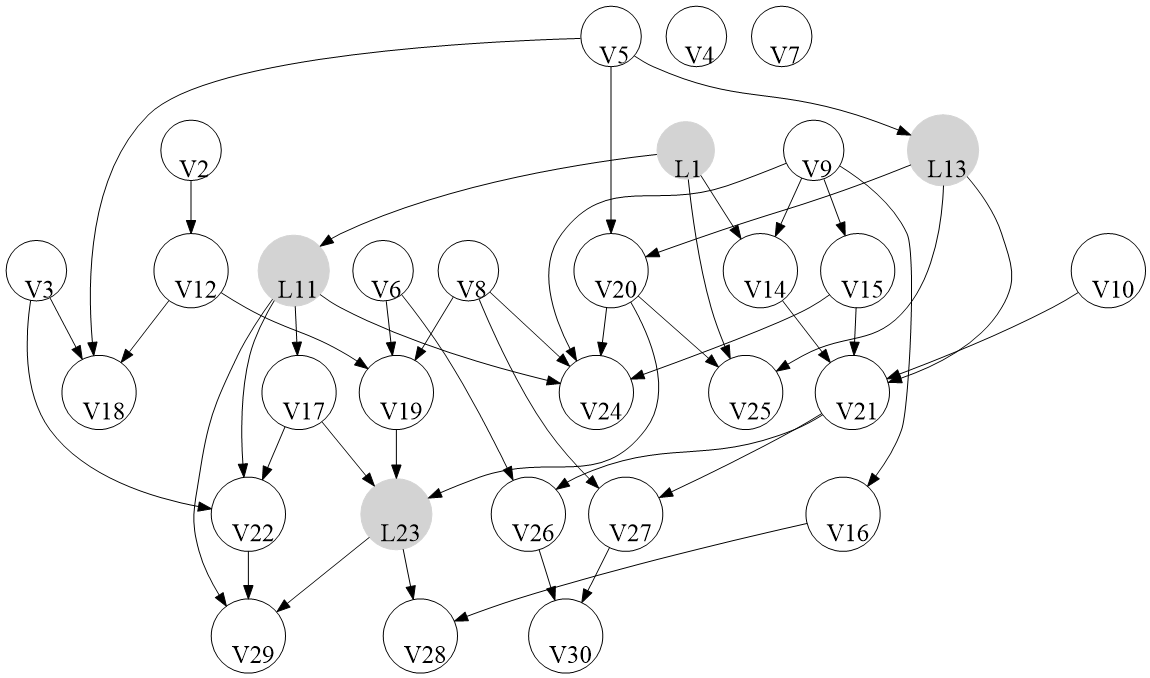

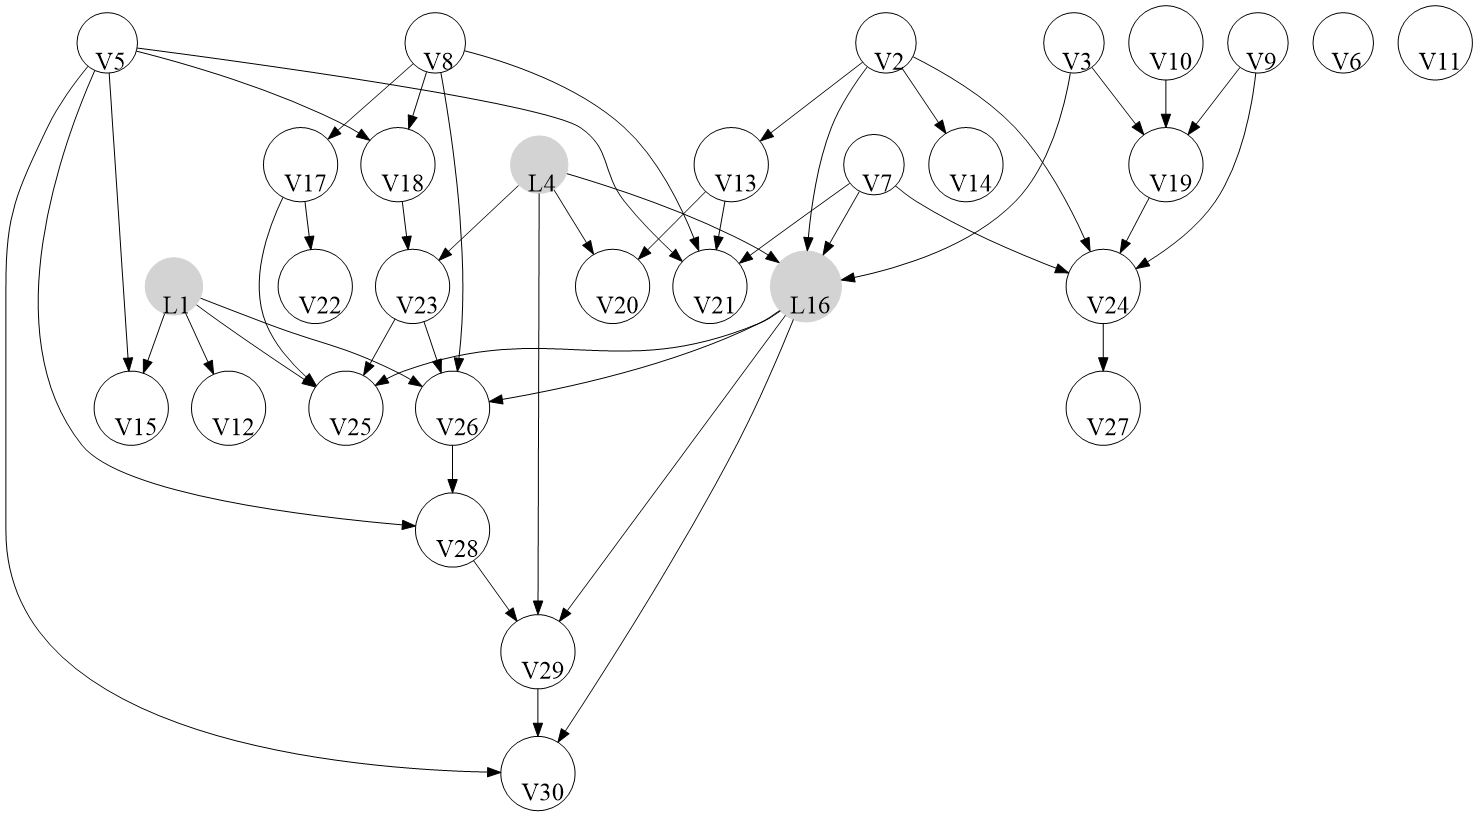

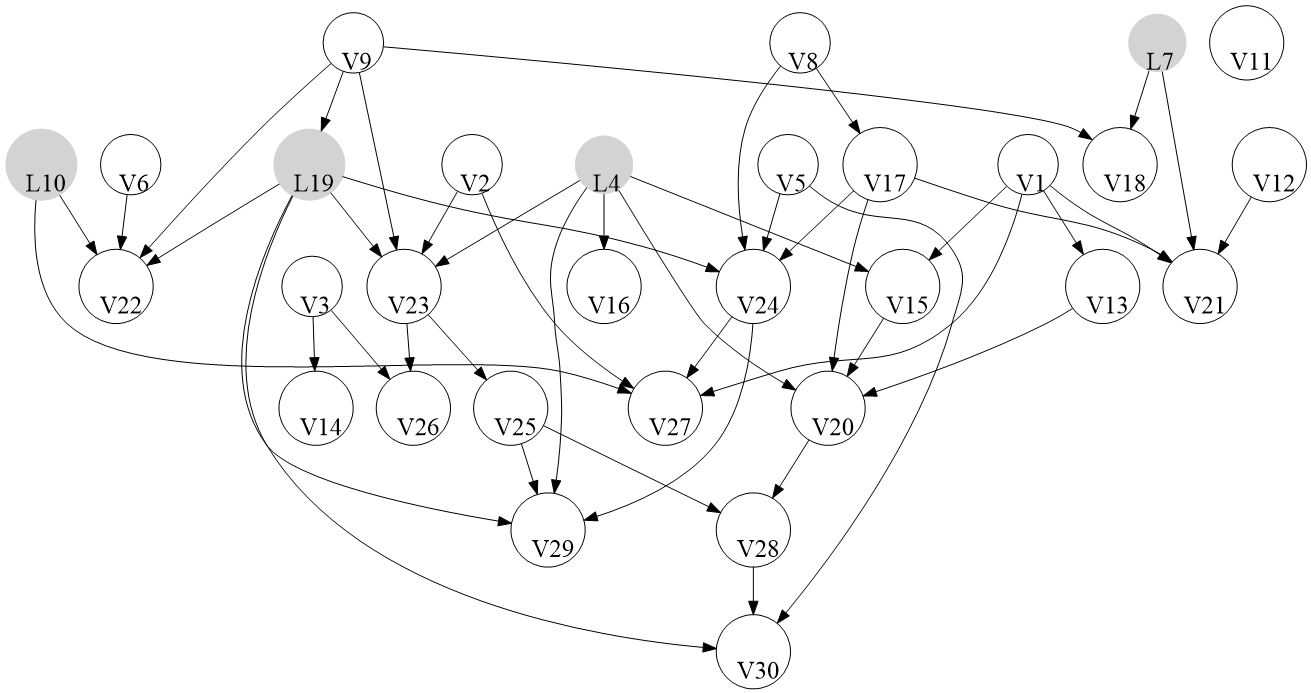

In [4]:
from fastdag2pag.mixgraph import MixGraph
from IPython.display import Image, display

load_graphs_paths = f"Test_Data/dags_{num_nodes}_{expected_degree}.json"
with open(load_graphs_paths, "r") as f:
    graphs = json.load(f)

for diff_id in diff_dis:
    graph_info = graphs[diff_id - 1]
    graph_csv = graph_info["graph"]
    graph_df = pd.read_csv(io.StringIO(graph_csv), index_col=0)
    dag = MixGraph()
    dag.from_pandas_adjacency(graph_df, graph_type='DAG')
    dag_pydot = dag.to_pydot()
    png_bytes = dag_pydot.create_png()
    display(Image(png_bytes))